# Dataset

In [1]:
import os
import numpy as np
import cv2
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#inverse augmentation funktion
def augment_inversion(image):   # Invertiert ein Bild nach zufälliger Auswahl
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.4:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image


def load_data(image_folder, mask_folder, image_size, gray):
    images = []
    masks = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(image_folder, filename)
            mask_path = os.path.join(mask_folder, filename)
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None and image is not None:
                #image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                
                image = cv2.resize(image, (image_size, image_size))
                #image = augment_inversion(image)
                
                #mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
                mask = cv2.resize(mask, (image_size, image_size))
                #mask = np.expand_dims(mask, axis=-1)
                images.append(image)
                masks.append(mask)
    return np.array(images), np.array(masks)

# Set your folders containing images and masks
image_folder =  os.path.abspath(os.getcwd()) + '/images'
mask_folder = os.path.abspath(os.getcwd()) + '/maske'

# Load data
images, masks = load_data(image_folder, mask_folder, image_size=128, gray=False)

In [6]:
images[0:5].shape

(5, 128, 128, 3)

In [3]:
# Normalize images
images = images.astype('float32') / 255.0
masks = masks.astype('float32') / 255.0


In [16]:
masks.shape, images.shape


((355, 128, 128), (355, 128, 128, 3))

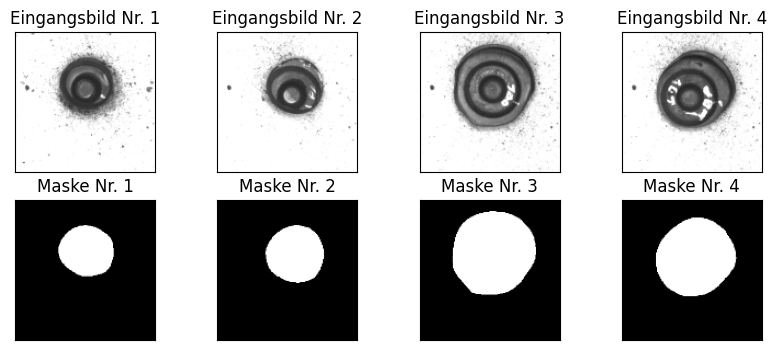

In [4]:
n = 4
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title("Eingangsbild Nr. " + str(i+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(masks[i])
    plt.title("Maske Nr. " + str(i+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Model Architecture

In [31]:

import tensorflow as tf


IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_12[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

# Train U-Net

In [33]:
# Train the model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = "segmentation_checkpoint.keras"
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)



history=model.fit(images, masks, batch_size=16, epochs=100, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])



Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 398ms/step - accuracy: 0.8227 - loss: 0.6660 - val_accuracy: 0.7878 - val_loss: 0.5886
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - accuracy: 0.8241 - loss: 0.4933 - val_accuracy: 0.7878 - val_loss: 0.3129
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.8244 - loss: 0.2229 - val_accuracy: 0.9006 - val_loss: 0.1676
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.9592 - loss: 0.0951 - val_accuracy: 0.9667 - val_loss: 0.0745
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - accuracy: 0.9821 - loss: 0.0353 - val_accuracy: 0.9786 - val_loss: 0.0426
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - accuracy: 0.9856 - loss: 0.0261 - val_accuracy: 0.9836 - val_loss: 0.0319
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - accuracy: 0.9869 - loss: 0.0222 - val_accuracy: 0.9846 - val_loss: 0.0293
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - accuracy: 0.9863 - loss: 0.0236 - val_acc

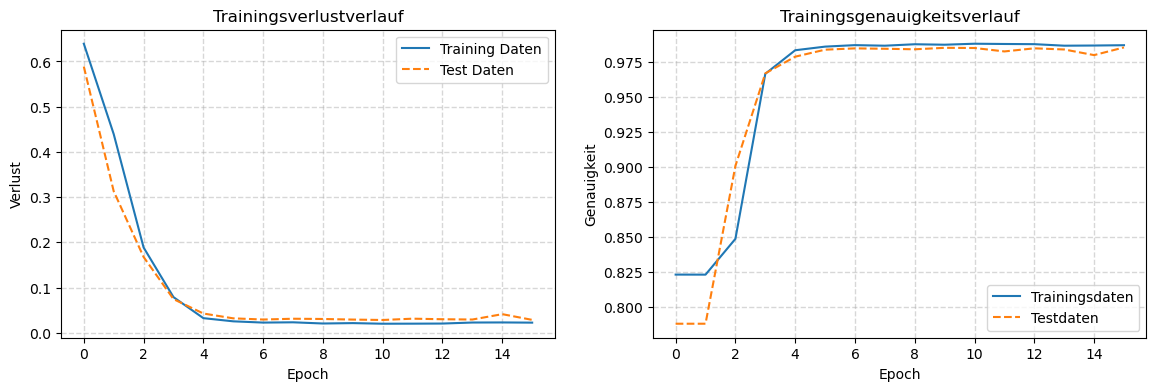

In [34]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Trainingsverlustverlauf')
    plt.xlabel('Epoch')
    plt.ylabel('Verlust')
    plt.plot(loss, label='Training Daten')
    plt.plot(val_loss, label='Test Daten', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Trainingsgenauigkeitsverlauf')
    plt.xlabel('Epoch')
    plt.ylabel('Genauigkeit')
    plt.plot(acc, label='Trainingsdaten')
    plt.plot(val_acc, label='Testdaten', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)


    plt.show()

# Grafische Darstellung der Trainings-Historie
render_training_history(history)

In [32]:
# Save the trained model
modelFileName = 'segmentation.keras'
model.save(modelFileName)
print('model saved as', modelFileName) 

model saved as segmentation.keras


# Prediction

In [5]:
#model laden
model = tf.keras.models.load_model('segmentation.keras',  custom_objects={'Lambda': tf.keras.layers.Lambda}, safe_mode=False)

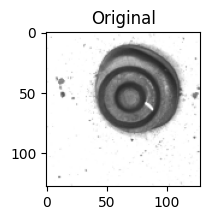

In [6]:
path= os.path.abspath(os.getcwd()) + '/images/'
size=128
image_test = []


tmp=cv2.imread(path+ str(200)+ '.png')
tmp = cv2.resize(tmp, (size, size))

           
image_test.append(tmp)
image_test.append(np.zeros_like(tmp))           
image_test=np.array(image_test)
# Display original images
plt.figure(figsize=(2, 2))
plt.imshow(image_test[0])
plt.title("Original")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


image_test = image_test.astype('float32') / 255.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


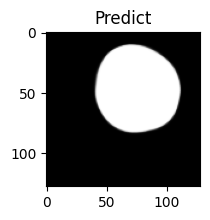

In [7]:

pre_img= model.predict(image_test[0:1])

#

cv2.imwrite("test.png", pre_img)
plt.figure(figsize=(2, 2))
plt.imshow(pre_img[0])
plt.title("Predict")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [128]:
#save = np.reshape(pre_img, (128, 128))
save = cv2.resize(save, (250, 250))
save = (save * 255).astype(np.uint8)

#äimage_test[pre_img == 255] = 255



cv2.imwrite("teswt.png",save)

True

In [8]:
pre=model.predict(images)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


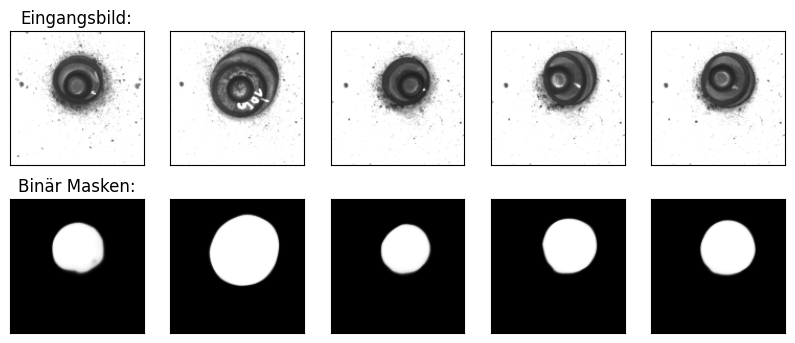

In [9]:
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i*7])
    if i==0:
        plt.title("Eingangsbild:")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pre[i*7])
    if i==0:
        plt.title("Binär Masken:")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
for i in range(200):
    save = cv2.resize(pre[i], (250, 250))
    save = (save * 255).astype(np.uint8)

    #edges = cv2.Canny(save, 50, 150)
    #contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #blank = np.zeros_like(save)
    #cv2.drawContours(blank, contours, -1, 255, thickness=cv2.FILLED)
    #cv2.imwrite("test/" +str(i+1) + ".png",blank)

    ret, save = cv2.threshold(save, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cut = images[i].copy()
    cut = cv2.resize(cut, (250, 250))
    cut = (cut * 255).astype(np.uint8)

    inv = images[i].copy()
    inv = cv2.resize(inv, (250, 250))
    inv = (inv * 255).astype(np.uint8)


    cnt= inv.copy()
    edges = cv2.Canny(save, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(cnt, contours, -1, 255, thickness=6)



    cut[save == 255] = [255, 255, 255]
    inv[save != 255] = [255, 255, 255]

    cv2.imwrite("test/maske_test/" + str(i+1) + ".png",save)
    cv2.imwrite("test/test_cut/" + str(i+1) + ".png",cut)
    cv2.imwrite("test/test_inv/" + str(i+1) + ".png",inv)
    cv2.imwrite("test/Kontur/" + str(i+1) + ".png",cnt)

In [38]:
def load_pre_data(image_folder, image_size, start, n):
    images = []
    for i in range(n):
        image_path = image_folder + str(i+start) + ".png"
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (image_size, image_size))
            images.append(image)
            
            
    return np.array(images)

In [39]:
start=201
image_folder = "C:/LUH\Master\Masterarbeit\Stereo_camera_program\Daten\crop/crop"


# Load data
predictieren= load_pre_data(image_folder, image_size=128, start=start, n=490)
predictieren = predictieren.astype('float32') / 255.0


In [40]:
new_pre=model.predict(predictieren)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step


In [41]:



for i in range(489):
    tmp = cv2.resize(new_pre[i], (250, 250))
    tmp = (tmp * 255).astype(np.uint8)

    #edges = cv2.Canny(save, 50, 150)
    #contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #blank = np.zeros_like(save)
    #cv2.drawContours(blank, contours, -1, 255, thickness=cv2.FILLED)
    #cv2.imwrite("test/" +str(i+1) + ".png",blank)

    ret, bin = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cut = predictieren[i].copy()
    cut = cv2.resize(cut, (250, 250))
    cut = (cut * 255).astype(np.uint8)

    inv = predictieren[i].copy()
    inv = cv2.resize(inv, (250, 250))
    inv = (inv * 255).astype(np.uint8)


    cnt= inv.copy()
    edges = cv2.Canny(bin, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(cnt, contours, -1, 255, thickness=1)



    cut[bin == 255] = [255, 255, 255]
    inv[bin != 255] = [255, 255, 255]

    cv2.imwrite("new/maske/" + str(i+start) + ".png",bin)
    cv2.imwrite("new/cut/" + str(i+start) + ".png",cut)
    cv2.imwrite("new/inv/" + str(i+start) + ".png",inv)
    cv2.imwrite("new/Kontur/" + str(i+start) + ".png",cnt)